In [1]:
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# 1. Installing Dependencies

In [2]:
#install specific version packages
import pkg_resources

#regular expression operations
import regex as re 

#emoticons
import emoji

#data visualization
from wordcloud import WordCloud

#Data management
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
np.random.seed(0)
from pandas_profiling import ProfileReport

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
#training
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import uniform, randint

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist #function to find the frequent words in the data

#preprocessing
from tqdm import tqdm
import spacy
from spacy.lang.en import English
import pickle

#ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Lightning Module
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks import LearningRateMonitor
from IPython.display import clear_output

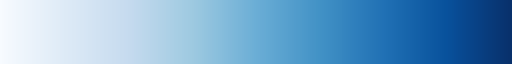

In [3]:
sns.color_palette("Blues",  as_cmap=True)

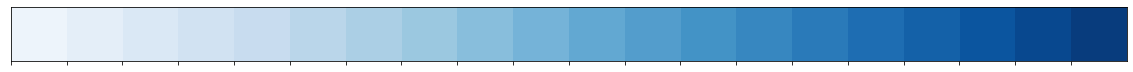

In [4]:
Blues_palette = sns.color_palette("Blues", 20)
sns.palplot(Blues_palette)

# 2. Exploratory Data Analysis

In [5]:
# train
path_train = '../input/twitter-entity-sentiment-analysis/twitter_training.csv'
df_train = pd.read_csv(path_train, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])
# test
path_test = '../input/twitter-entity-sentiment-analysis/twitter_validation.csv'
df_test = pd.read_csv(path_test, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

In [6]:
display(df_train)

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
display(df_test)

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [8]:
df_train.shape, df_test.shape

((74682, 4), (1000, 4))

## Dropping nan

In [9]:
df_train.isnull().sum(), df_test.isnull().sum()

(Tweet_ID           0
 Entity             0
 Sentiment          0
 Tweet_Content    686
 dtype: int64,
 Tweet_ID         0
 Entity           0
 Sentiment        0
 Tweet_Content    0
 dtype: int64)

In [10]:
df_train.dropna(inplace=True, axis=0)
df_test.dropna(inplace=True, axis=0)

In [11]:
df_train.shape, df_test.shape

((73996, 4), (1000, 4))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       73996 non-null  int64 
 1   Entity         73996 non-null  object
 2   Sentiment      73996 non-null  object
 3   Tweet_Content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_Content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


## Automated Data Profiling using Pandas-profiling

In [14]:
profile = ProfileReport(df_train, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
print('Distinct Values: \n')
col = ['Entity','Sentiment']
for i in col:
    print(i,'->')
    print(df_train[i].value_counts())
    print('\n')

Distinct Values: 

Entity ->
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Borde

## Text Analysis

In [16]:
df_train.columns

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content'], dtype='object')

In [17]:
texts = df_train['Tweet_Content']

In [18]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

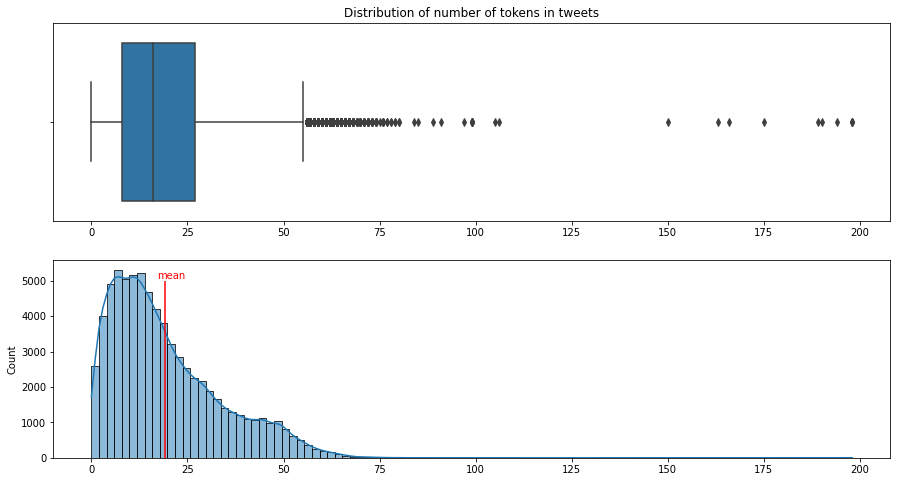

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].set_title('Distribution of number of tokens in tweets')

sns.boxplot(x = text_lens, ax=axes[0])
sns.histplot(x=text_lens, bins=100, kde=True, ax=axes[1], palette=Blues_palette)
axes[1].vlines(len_mean, 0, 5000, color = 'r')
plt.annotate("mean", xy=(len_mean, 5000), xytext=(len_mean-2, 5050), color='r')
plt.show()

Mean length of tweets ~ 23 tokens

## Understanding Outliers

In [20]:
extreme_outliers = df_train['Tweet_Content'][np.array(text_lens) > 125]

In [21]:
TARGET = 'Sentiment'

In [22]:
for idx in extreme_outliers.index:
    print(idx, 'Target', df_train[TARGET][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

1826 Target Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

8546 Target Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

10454 Target Positive
_ _ _ _ _ _ 

## Target Analysis

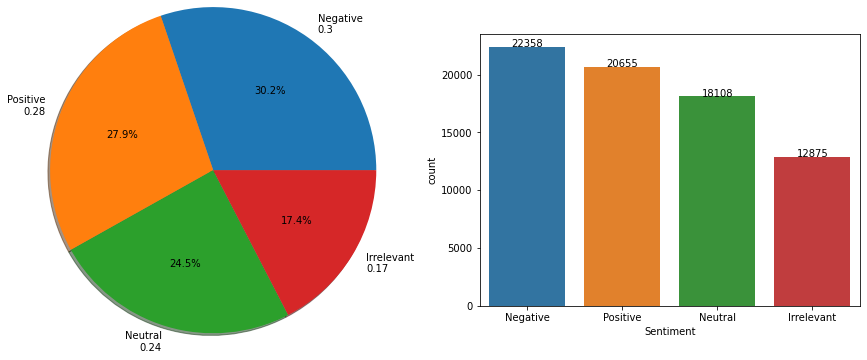

In [23]:
#Visualizing Sentiment feature - Target feature
plt.figure(figsize=(15,5))

#plot pie chart
target_balance = df_train[TARGET].value_counts()
plt.subplot(1,2,1)
label = [f'{idx}\n{round(target_balance[idx]/len(df_train), 2)}' for idx in target_balance.index]
label_count = df_train['Sentiment'].value_counts().values
plt.pie(data=df_train, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

#plot countplot
label = df_train['Sentiment'].value_counts().index
plt.subplot(1,2,2)
ax = sns.countplot(x='Sentiment', data=df_train, order=label)
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),
    y=height+0.2,ha='center',s='{:.0f}'.format(height))
plt.show()

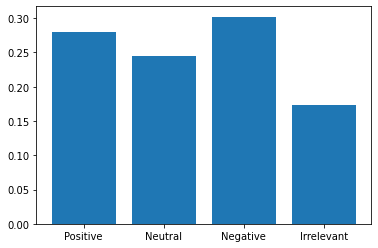

In [24]:
#Checking balance of target classes
sentiments = list(df_train["Sentiment"].unique())

sentiment_nums = [len(df_train[df_train["Sentiment"] == sentiment]) / len(df_train) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)
plt.show()

In [25]:
# top words
stopwords_list = stopwords.words('english')

word_counts = {
    'Positive': [],
    'Neutral': [],
    'Irrelevant': [],
    'Negative': []
}

pattern = re.compile('[^\w ]')
for text, t in zip(df_train['Tweet_Content'], df_train[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

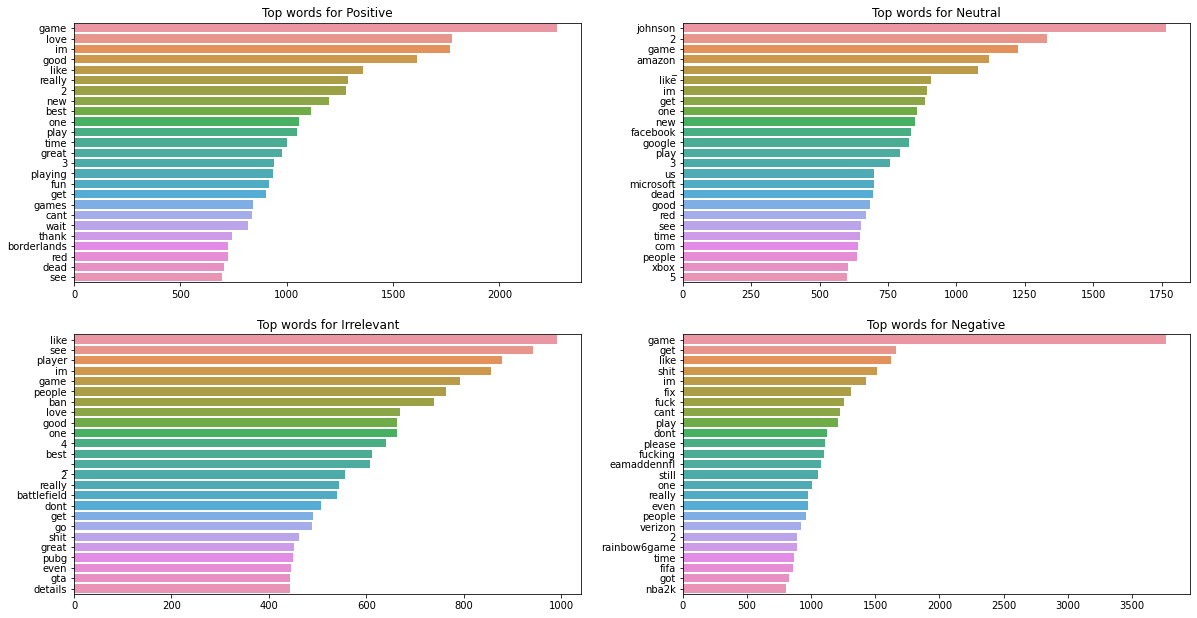

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))

for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')

plt.show()

most correlated words for each topic using chi2

In [27]:
tfidf = TfidfVectorizer(
    sublinear_tf=True, min_df=5,
    ngram_range=(1, 2), 
    stop_words='english',
    max_features=10000
)

features = tfidf.fit_transform(df_train['Tweet_Content']).toarray()

labels = df_train[TARGET]

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 73996 Text is represented by 10000 features (TF-IDF score of unigrams and bigrams)


In [28]:
N = 10
for label in set(labels):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Irrelevant:
  * Most Correlated Unigrams are: battlefield, montage, eamaddennfl, verizon, johnson, details, occurred, ban, bf4db, player
  * Most Correlated Bigrams are: johnson johnson, home depot, ban 100, ban battlefield, battlefield player, occurred details, details bf4db, bf4db com, com player, player ban

==> Neutral:
  * Most Correlated Unigrams are: tt, dlvr, 2020, check, com, amazon, achievement, earned, https, johnson
  * Most Correlated Bigrams are: twitch tv, johnson stop, stop selling, ift tt, watch video, check video, johnson johnson, chance win, com 2020, just earned

==> Negative:
  * Most Correlated Unigrams are: sucks, love, shit, rainbow6game, wtf, servers, nba2k, fuck, eamaddennfl, fix
  * Most Correlated Bigrams are: details bf4db, red dead, bf4db com, player ban, com player, fix servers, eamaddennfl fix, rainbow6game fix, fix game, twitch tv

==> Positive:
  * Most Correlated Unigrams are: good, amazing, thank, creed, nice, excited, fun, wow, wait, love
  * M

In [29]:
# len for classes without outliers
tweets_len = {
    'Positive': [],
    'Neutral': [],
    'Irrelevant': [],
    'Negative': []
}

pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame(
    [len(re.sub(pattern, '', text).lower().split()) for text in df_train['Tweet_Content'] if len(text)<125],
        columns=['len'])

In [30]:
tweets_len['target'] = df_train[TARGET]

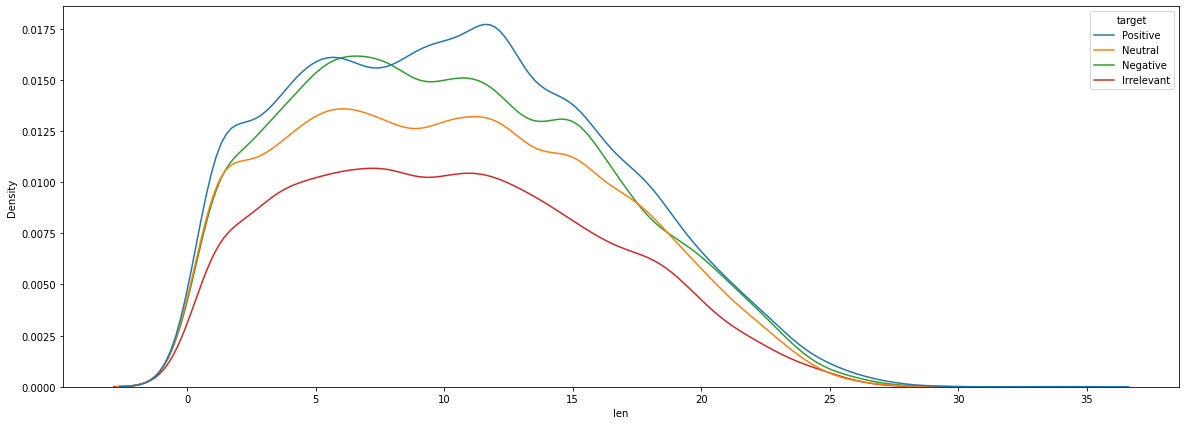

In [31]:
plt.figure(figsize=(20, 7))
sns.kdeplot(data=tweets_len, x='len', hue='target')
plt.show()

Distributions of tweet lengths dont differ from each other. We can ensure using [ANOVA test](https://www.simplypsychology.org/anova.html#:~:text=An%20ANOVA%20test%20is%20a,into%202%20or%20more%20groups.) as there is equal dispersion and normal-like distribution

In [32]:
#perform two-way ANOVA
model = ols('len ~ target', data=tweets_len).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
target,2.096246e+02,3.0,1.986563,0.113603
Residual,1.696781e+06,48240.0,NaN,NaN


p-value > 0.05

In [33]:
# emoticons
def split_count(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [34]:
target_emojis = {
    'Positive': [],
    'Neutral': [],
    'Irrelevant': [],
    'Negative': []
}

pattern = re.compile('\u200d')
for i, text in enumerate(texts):
    emoji_count = [e for e in text if e in emoji.EMOJI_DATA]
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[df_train[TARGET].iloc[i]].extend(emoji_count)

Top emojis for Positive 
 ['🤣', '🥰', '🥺', '🤦', '🤔', '🤩', '🥳', '™', '🤯', '🤷', '🦁', '‼', '🤖', '🥴', '🤤', '🥵', '🤸', '🤞', '🦊', '🤟']


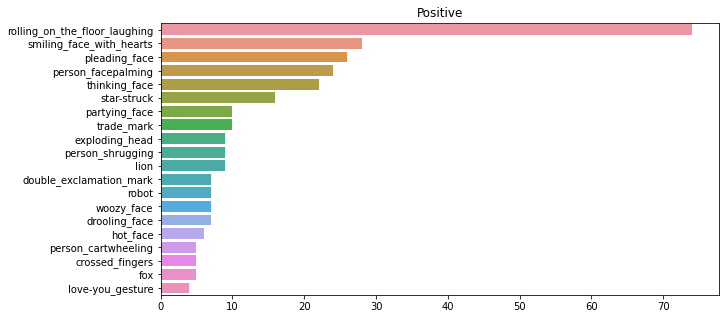

Top emojis for Neutral 
 ['🤣', '🤔', '🤦', '🥺', '™', '🤷', '©', '🤩', '🥰', '‼', '🤯', '🥳', '🤠', '🤡', '🤨', '🤬', '🧨', '🧐', '🥴', '🥈']


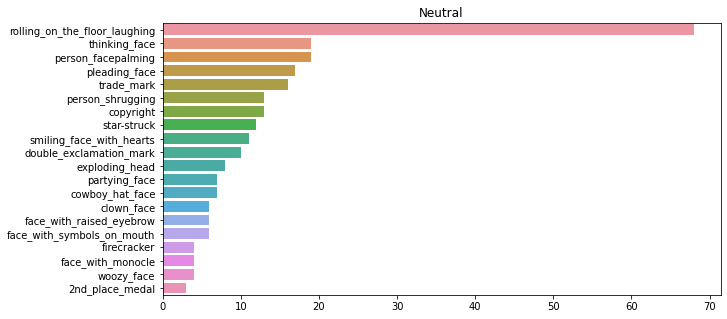

Top emojis for Irrelevant 
 ['🤣', '🥺', '🥰', '🤦', '🤷', '🤔', '🥳', '🤗', '🥴', '🤪', '🧘', '🤧', '🦋', '🤓', '🤬', '🤢', '‼', '🤡', '🥄', '🤞']


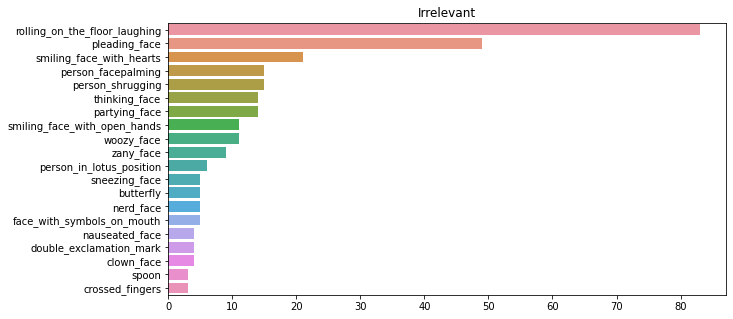

Top emojis for Negative 
 ['🤦', '🤣', '🥺', '🤬', '🥴', '🤷', '🤔', '™', '🧢', '🤡', '🤢', '🤩', '🤑', '‼', '🤪', '©', '🥰', '🤨', '🤓', '🤟']


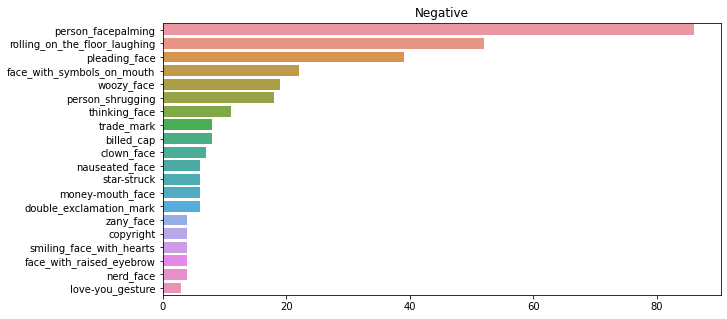

In [35]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(10, 5))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print('=========='*10,  f'\nTop emojis for {t} \n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
        
    plt.title(f'{t}')
    plt.show()

In [36]:
# capitalization distribution
capitalized = [np.sum([t.isupper() for t in text.split()]) for text in np.array(df_train['Tweet_Content'])]

In [37]:
capitalized_target = pd.DataFrame([(c, t) for c, t in zip(capitalized, df_train[TARGET])], columns=['cap', 'target'])

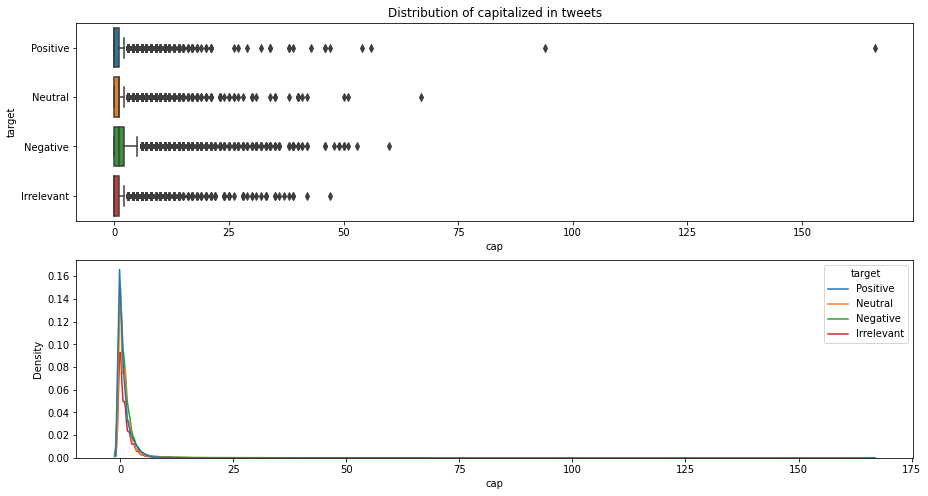

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of capitalized in tweets')
sns.boxplot(x=capitalized_target['cap'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target, x='cap', hue='target', ax=axes[1])
plt.show()

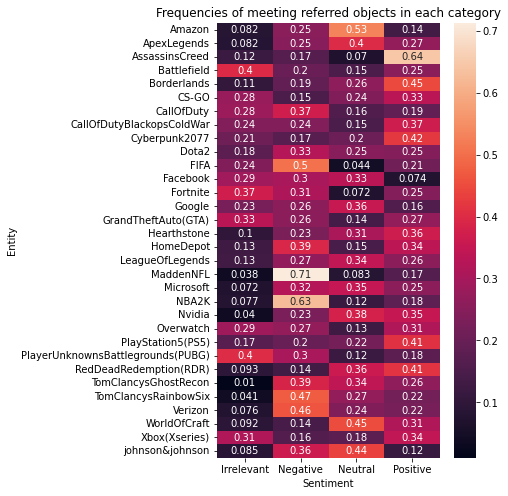

In [39]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.crosstab(df_train['Entity'], df_train[TARGET], normalize='index'), annot=True)
plt.title('Frequencies of meeting referred objects in each category')
plt.show()

In [40]:
# removing outliers
# all outliers: 1826 8546 10454 32186 43712 52136 61388 68078 68576 68624 70940
ids_to_remove = [1826, 10454, 32186, 68078]
df_train = df_train[~df_train.index.isin(ids_to_remove)]
df_train.index = range(len(df_train))

In [41]:
sns.set(style = 'white')

### Positive

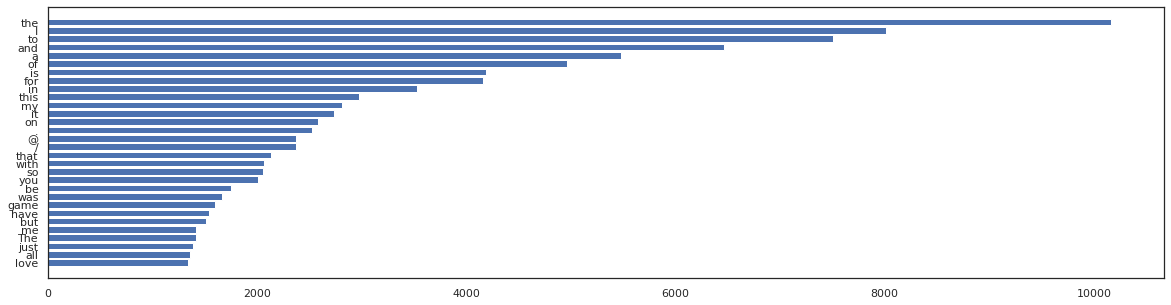

In [42]:
# Subset positive review dataset
all_words_df = df_train.loc[df_train['Sentiment'] == 'Positive',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['Tweet_Content']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

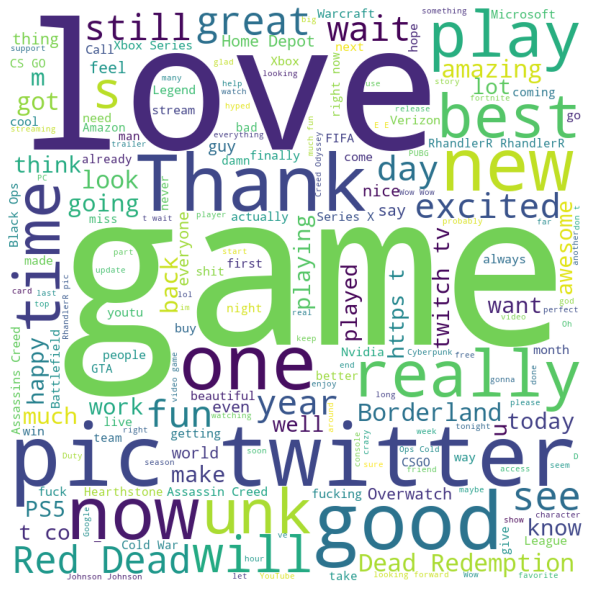

In [43]:
word_cloud_df = df_train.loc[df_train['Sentiment'] == 'Positive',:]
all_words = ' '.join([text for text in word_cloud_df['Tweet_Content']])
 
wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Neutral

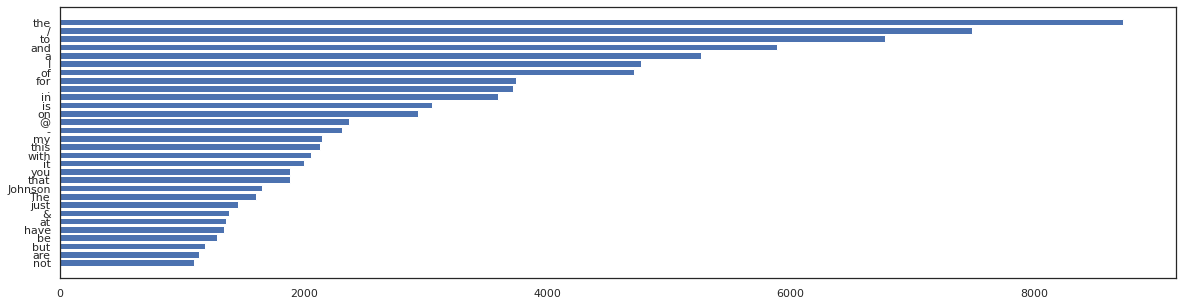

In [44]:
# Subset neutral review dataset
all_words_df = df_train.loc[df_train['Sentiment'] == 'Neutral',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['Tweet_Content']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

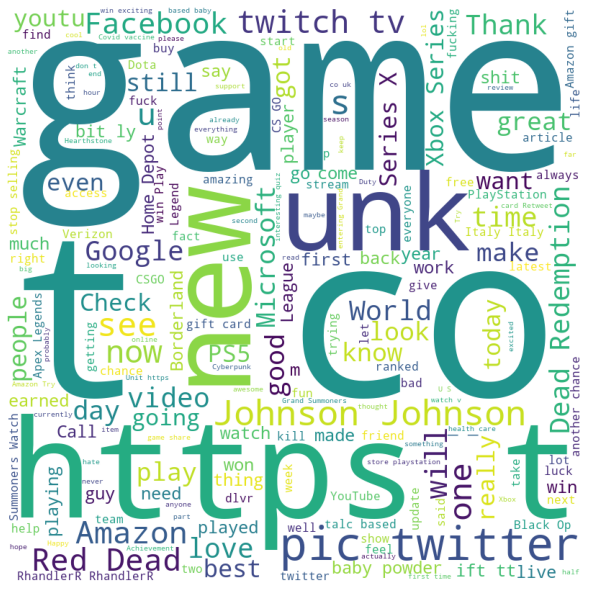

In [45]:
word_cloud_df = df_train.loc[df_train['Sentiment'] == 'Neutral',:]
all_words = ' '.join([text for text in word_cloud_df['Tweet_Content']])
 
wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Negative

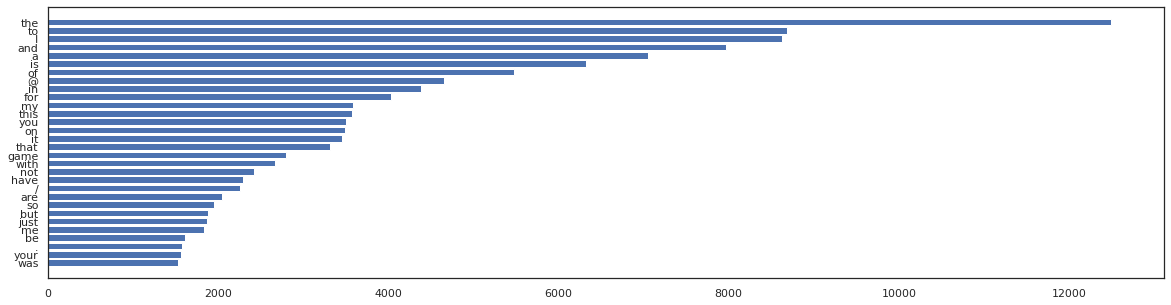

In [46]:
# Subset positive review dataset
all_words_df = df_train.loc[df_train['Sentiment'] == 'Negative',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['Tweet_Content']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

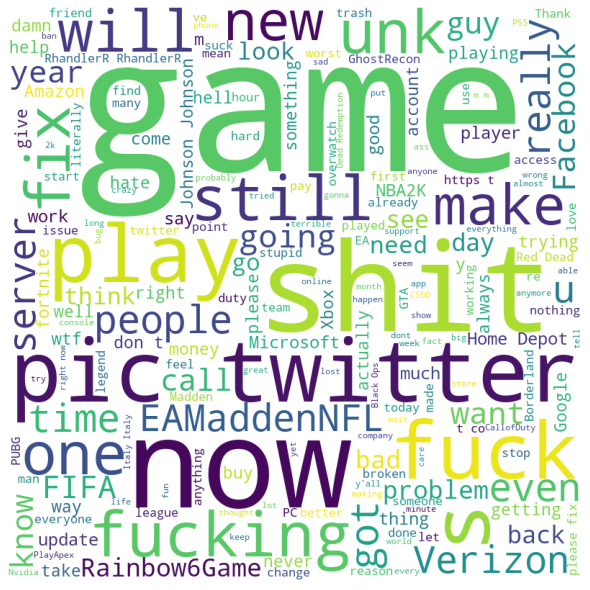

In [47]:
word_cloud_df = df_train.loc[df_train['Sentiment'] == 'Negative',:]
all_words = ' '.join([text for text in word_cloud_df['Tweet_Content']])
 
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Irrelevant

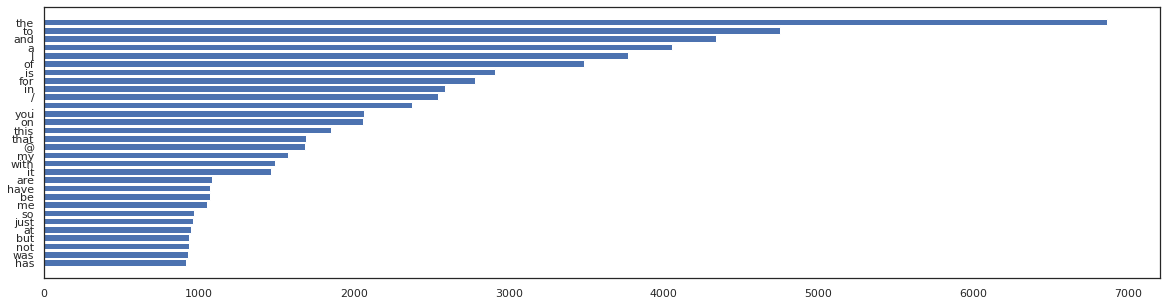

In [48]:
# Subset positive review dataset
all_words_df = df_train.loc[df_train['Sentiment'] == 'Irrelevant',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df['Tweet_Content']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

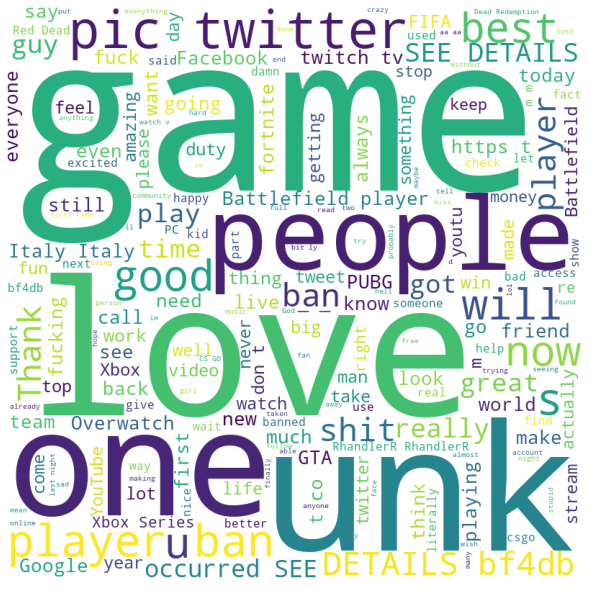

In [49]:
word_cloud_df = df_train.loc[df_train['Sentiment'] == 'Irrelevant',:]
all_words = ' '.join([text for text in word_cloud_df['Tweet_Content']])

wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Preprocessing
1. Sentiment is mostly expressed at lexical and punctuational levels
2. we can use emoticons to represent emotions
3. semantic features of words and syntactic relations arent important. Hence we can use simple tf-idf encoders in which we include punctuation (! and ?), case (CapsLoc : signal of strong emotions) and emojis

### Steps:
1. lowercase words (count for each text how many characters or words were capitalized)
2. remove stopwords and numbers (are sentiment neutral)
3. decode emojis
4. [lemmatize](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)
5. vectorize with tf-idf
6. Add refers to feature ohe
7. delete nans

In [50]:
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

1. Remove urls
2. Remove double spaces
3. Remove punctuation
4. Remove contractions
4. Remove stopwords
5. Remove numbers
6. Remove mentions
7. Remove hashtags
8. decode emojis
9. Lemmatize

In [51]:
# dictionary of contractions
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
    "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
    "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", 
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
    "you've": "you have"
}

In [52]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.vectorizer = TfidfVectorizer(
            lowercase=False, max_features=8000, min_df=10, 
            ngram_range=(1, 3), tokenizer=None
        )
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_contractions(self, texts, contraction_mapping):
        print('Removing contractions...')
        return [' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")]) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]

    def remove_mentions(self, texts):
        print('Removing user-mentions...')
        return [re.sub(r'@[A-Za-z0-9]+', '', text) for text in texts]

    def remove_hashtags(self, texts):
        print('Removing hashtags...')
        return [re.sub('#', '', text) for text in texts]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
    
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()] # delete nans
        X = X[~X.duplicated()] # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
            
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)] # count capitalized
        
        print('\n|||| Preprocessing ||||\n')
        X = [text.lower() for text in X] # lower
        X = self.remove_urls(X)          # remove urls
        X = self.remove_punctuation(X)   # remove punctuation
        X = self.remove_contractions(X, contraction_mapping)  # remove contractions
        X = self.remove_mentions(X)      # remove user-mentions
        X = self.remove_hashtags(X)      # remove hashtags
        X = self.remove_double_space(X)  # remove double space
        X = self.decode_emojis(X)        # decode emojis
        X = self.remove_stopwords(X)     # remove stopwords
        X = self.remove_numbers(X)       # remove numbers                      
        X = self.lemmatize(X)            # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X) # vectorize
        
        print('\n|||| Preprocessing Complete. ||||\n')
        return X

In [53]:
pr = Preprocessor()

In [54]:
data_train = df_train
data_test = df_test

y_train = df_train['Sentiment']
y_test = df_test['Sentiment']

In [55]:
data_train_pr = pr.transform(data_train['Tweet_Content'])
data_train_pr = pd.DataFrame.sparse.from_spmatrix(data_train_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['Entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_train = pd.concat([data_train_pr, referring_ohe], axis=1)
y_train = y_train[y_train.index.isin(pr.train_idx)]
y_train.index = X_train.index

Removing Nans...
Counting capitalized...

|||| Preprocessing ||||

Removing URLs...
Removing punctuation...
Removing contractions...
Removing user-mentions...
Removing hashtags...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 69488/69488 [00:00<00:00, 207389.50it/s]


Removing numbers...


100%|██████████| 69488/69488 [00:00<00:00, 505732.77it/s]


Lemmatizing...


100%|██████████| 69488/69488 [07:21<00:00, 157.52it/s]


Fitting vectorizer...
Vectorizing...

|||| Preprocessing Complete. ||||



In [56]:
data_test_pr = pr.transform(data_test['Tweet_Content'], mode='test')
data_test_pr = pd.DataFrame.sparse.from_spmatrix(data_test_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['Entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_test['Entity'][data_test.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_test = pd.concat([data_test_pr, referring_ohe], axis=1)
y_test = y_test[y_test.index.isin(pr.test_idx)]
y_test.index = X_test.index

Removing Nans...
Counting capitalized...

|||| Preprocessing ||||

Removing URLs...
Removing punctuation...
Removing contractions...
Removing user-mentions...
Removing hashtags...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 999/999 [00:00<00:00, 143320.21it/s]


Removing numbers...


100%|██████████| 999/999 [00:00<00:00, 296330.25it/s]


Lemmatizing...


100%|██████████| 999/999 [00:06<00:00, 154.17it/s]


Vectorizing...

|||| Preprocessing Complete. ||||



## Save Prepared Data

In [57]:
# save prepared data for the future
with open('../X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('../X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('../y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('../y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)
    
# open prepared data
# with open('../X_train.pkl', 'rb') as f:
#     X_train = pickle.load(f)
# with open('../X_test.pkl', 'rb') as f:
#     X_test = pickle.load(f)
# with open('../y_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../y_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

# 3. Training

In [58]:
def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1_weighted'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

    cv = RandomizedSearchCV(
        model,
        params,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        verbose=2,
        random_state=1
    )
    
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [59]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
}

## Pytorch Lightening Classifier
building a neural network using pytorch lightning.

In [60]:
# open saved preprocessed data
with open('../X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('../X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [61]:
torch.manual_seed(42)

def plot_loss(losses, title=''):
    """
    plots and saves loss progression while fitting
    """
    if len(losses) < 3:
        return

    pos = np.vstack(losses)
    x, y = pos.T
    plt.clf()
    plt.ion()
    plt.figure(figsize=(9, 5))
    plt.plot(x, y)
    plt.title(title)
    clear_output(wait=True)
    plt.show()

class NNSentimentClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.model = nn.Sequential(
            nn.Linear(8032, 1000),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1000, 100),
            nn.Tanh(),
            self.dropout,
            nn.Linear(100, 1000),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1000, 10),
            nn.ReLU(),
            self.dropout,
            nn.Linear(10, 4)
        )
        self.acc_train_loss = []
        self.acc_val_loss = []
    
    def forward (self, x):
        prediction = self.model(x)
        return prediction
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
    
    def test_step(self, test_batch, batc_idx):
        x, y = test_batch
        y = y.long()
        prediction = model.forward(x.float())
        preds = torch.argmax(prediction, dim=1)

        return preds

In [62]:
# data
target_to_idx = {
    'Irrelevant': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3
}

y_train_idx = torch.from_numpy(y_train.map(target_to_idx).values.astype(float))
train_data_tensor = data_utils.TensorDataset(torch.from_numpy(X_train.to_numpy().astype(float)), y_train_idx)
train_data_tensor, val_data_tensor = random_split(train_data_tensor, [62540, 6948])
train_loader = DataLoader(train_data_tensor, batch_size=32)

val_loader = DataLoader(val_data_tensor, batch_size=1)

In [63]:
# model
model = NNSentimentClassifier()
print(model)

NNSentimentClassifier(
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (model): Sequential(
    (0): Linear(in_features=8032, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1000, out_features=100, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=1000, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=1000, out_features=10, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=10, out_features=4, bias=True)
  )
)


to solve [error](https://forums.fast.ai/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/96174/2) we use cpu instead of gpu

In [66]:
# training

# end cancel after epoch 8

#using gpu
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, limit_train_batches=0.5, max_epochs=50)
trainer.fit(model, train_loader, val_loader)

Adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

In [68]:
y_test_idx = torch.from_numpy(y_test.map(target_to_idx).values.astype(float))
test_data_tensor = data_utils.TensorDataset(torch.from_numpy(X_test.to_numpy().astype(float)), y_test_idx)
test_loader = DataLoader(test_data_tensor, batch_size=1)

In [69]:
preds = []
for batch in test_loader:
    x, y = batch
    y = y.long()
    prediction = model.forward(x.float().cuda())
    preds.extend(torch.argmax(prediction, dim=1).cpu())

In [70]:
print(classification_report(preds, y_test_idx))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       161
           1       0.95      0.97      0.96       262
           2       0.95      0.92      0.93       296
           3       0.93      0.92      0.93       280

    accuracy                           0.94       999
   macro avg       0.93      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999



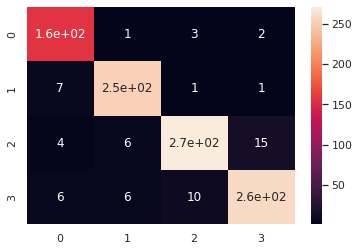

In [71]:
sns.heatmap(confusion_matrix(preds, y_test_idx), annot=True)
plt.show()

## we've got 94% accuracy

neutral class predicted less accurate than the others due to nature of classes where "middle position" is not that destinctive as the polar positions

In [72]:
# save the network 
torch.save(model.state_dict(), 'net.pt')

# Predictions on Unseen Data

In [84]:
df_train['Entity'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [95]:
# modify below data dictionary for new input
# Entity should lie in above list
data = {
    'Entity': [
        'Google',
        'LeagueOfLegends',
        'Amazon',
        'Facebook',
        'Google'
    ],
    'Sentiment': [
        'Neutral', 
        'Positive', 
        'Negative', 
        'Neutral',
        'Positive'
    ],
    'Tweet_Content': [
        'Billions of Tweets reveal what brands should know to stay ahead of the curve. Download the 2022 Twitter Trends India Report and get insights into what people on Twitter are talking about 👇', 
        'Im so happy for you @rockdan, #wearehappy, good for you my dude. 99999, time for League of legends today??', 
        'I am very upset by seeing this. #ShameOnNDTV. This is very sad I have not accepting this from such a big national television channel😔', 
        'Prime Minister @narendramodi visited the residence of Union Minister @PiyushGoyal in Delhi and offered prayers to Lord Ganesh idol on the occasion of #GaneshChaturthi yesterday.',
        'surprised and extremely happy by @google response on the recent events #amazing 😄'
    ]
} 
df_new = pd.DataFrame.from_dict(data)
df_new

,Entity,Sentiment,Tweet_Content
0,Google,Neutral,Billions of Tweets reveal what brands should k...
1,LeagueOfLegends,Positive,"Im so happy for you @rockdan, #wearehappy, goo..."
2,Amazon,Negative,I am very upset by seeing this. #ShameOnNDTV. ...
3,Facebook,Neutral,Prime Minister @narendramodi visited the resid...
4,Google,Positive,surprised and extremely happy by @google respo...


In [96]:
data_new = df_new

y_new = df_new['Sentiment']

In [97]:
data_new_pr = pr.transform(data_new['Tweet_Content'], mode='test')
data_new_pr = pd.DataFrame.sparse.from_spmatrix(data_new_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['Entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_new['Entity'][data_new.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_new = pd.concat([data_new_pr, referring_ohe], axis=1)
y_new = y_new[y_new.index.isin(pr.test_idx)]
y_new.index = X_new.index

Removing Nans...
Counting capitalized...

|||| Preprocessing ||||

Removing URLs...
Removing punctuation...
Removing contractions...
Removing user-mentions...
Removing hashtags...
Removing double space...
Decoding emojis...
Removing stopwords...



100%|██████████| 5/5 [00:00<00:00, 22145.22it/s]


Removing numbers...



100%|██████████| 5/5 [00:00<00:00, 50412.31it/s]


Lemmatizing...



100%|██████████| 5/5 [00:00<00:00, 132.04it/s]

Vectorizing...

|||| Preprocessing Complete. ||||



In [98]:
y_new_idx = torch.from_numpy(y_new.map(target_to_idx).values.astype(float))
new_data_tensor = data_utils.TensorDataset(torch.from_numpy(X_new.to_numpy().astype(float)), y_new_idx)
new_loader = DataLoader(new_data_tensor, batch_size=1)

In [99]:
preds = []
for batch in new_loader:
    x, y = batch
    y = y.long()
    prediction = model.forward(x.float().cuda())
    preds.extend(torch.argmax(prediction, dim=1).cpu())

In [100]:
target_to_idx

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [101]:
preds

[tensor(0), tensor(3), tensor(1), tensor(0), tensor(3)]

<table>
    <tr>
        <th>Expected Output</th>
        <th>Actual Output</th>
    </tr>
    <tr>
        <td>Neutral(0)</td>
        <td>Neutral(0)</td>
    </tr>
    <tr>
        <td>Positive(3)</td>
        <td>Positive(3)</td>
    </tr>
    <tr>
        <td>Negative(1)</td>
        <td>Negative(1)</td>
    </tr>
    <tr>
        <td>Neutral(0)</td>
        <td>Neutral(0)</td>
    </tr>
    <tr>
        <td>Positive(3)</td>
        <td>Positive(3)</td>
    </tr>
</table>

# Save Model

can also use these commands alternatively: 
1. `!tar -zcvf file_name.tar.gz /kaggle/working`
2. `<a href="file_path"> Download File </a>`

In [74]:
import os
os.chdir(r'/kaggle/working')

In [75]:
from IPython.display import FileLink
FileLink(r'net.pt')

/kaggle/working/net.pt

In [ ]:
# create zip of kaggle/working/ directory inside kaggle/working
# !tar -zcvf working.tar.gz /kaggle/working

# Conclusion

To solve the given task, raw data was preprocessed as follows:

1. Texts were cleaned from punctuation, urls etc.
2. Texts were lemmatized
3. Texts were vectorized with TF-IDF vectorizer.
4. Categorical features were one-hot-encoded.

In this notebook Neural Networks was implemented which resulted in `94% Accuracy`

# References

1. https://www.kaggle.com/code/katearb/sentiment-analysis-in-twitter-93-test-acc
2. https://www.kaggle.com/code/parisrohan/text-feature-cleaning-generation-model-building
3. https://www.kaggle.com/code/cameronwatts/bag-of-words-sentiment-analysis-with-keras-task
4. https://www.kaggle.com/code/vaishnavi28krishna/twitter-analysis-using-dt-and-rfdtc